In [1]:
import os
import cv2
import torch
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
from albumentations import Resize, Compose, Normalize
from albumentations.pytorch import ToTensorV2

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Masrafe/Coding/Git_Hub_code/ml_project/road_damage/pothole_detection_CNN-main/Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [7]:
len(dataset)

48

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 0 2 2 1 1 2 1 1 1 0 0 1 1 2 0 0 0 0 2 1 2 2 1 0 2 2 0 2 2 0 0]


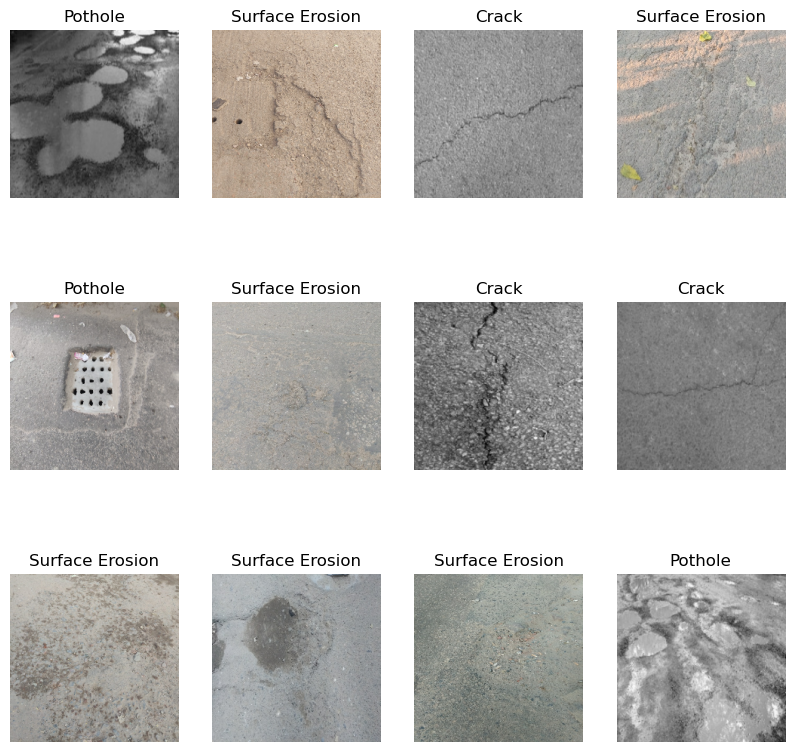

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [11]:
train_data = dataset.take(38)
len(train_data)

38

In [12]:
test_data = dataset.skip(38)
len(test_data)

10

In [13]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [14]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [15]:
test_data = test_data.skip(4)
len(test_data)

6

In [16]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [89]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [17]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

38
4
6


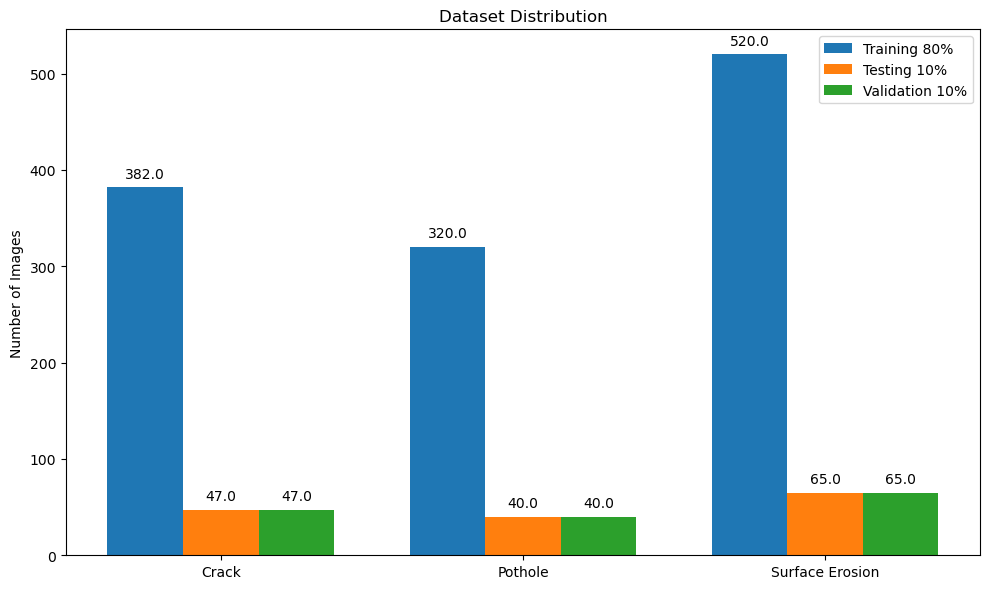

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Categories and dataset splits
categories = ['Crack', 'Pothole', 'Surface Erosion']
training_counts = [np.floor(478*0.8), np.floor(401*0.8), np.floor(651*0.8)]
testing_counts = [np.floor(478*0.1), np.floor(401*0.1), np.floor(651*0.1)]
validation_counts = [np.floor(478*0.1), np.floor(401*0.1), np.floor(651*0.1)]


x = np.arange(len(categories))  # label locations
width = 0.25  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, training_counts, width, label='Training 80%')
bars2 = ax.bar(x, testing_counts, width, label='Testing 10%')
bars3 = ax.bar(x + width, validation_counts, width, label='Validation 10%')

# Add text labels on top of bars
for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, str(bar.get_height()), ha='center')

# Labels and formatting
ax.set_ylabel('Number of Images')
ax.set_title('Dataset Distribution')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()


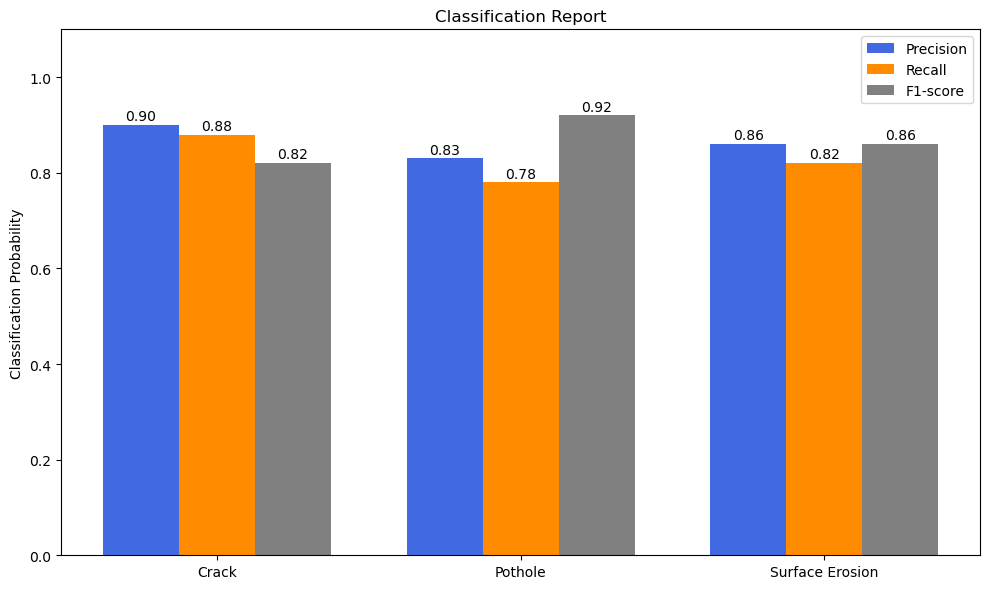

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Crack', 'Pothole', 'Surface Erosion']
precision = [0.90  ,    0.83  ,    0.86         ]
recall = [0.88    ,  0.78     , 0.82           ]
f1_score = [0.82   ,   0.92  ,    0.86          ]

x = np.arange(len(categories))  # label locations
width = 0.25  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='royalblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='darkorange')
bars3 = ax.bar(x + width, f1_score, width, label='F1-score', color='gray')

# Add text labels on top of bars
for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", ha='center')

# Labels and formatting
ax.set_ylabel('Classification Probability')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


In [91]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F
import random
# === Data Augmentation Transforms ===
basic_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomCrop(224, padding=10),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

In [92]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [93]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [94]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [95]:
def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        #basic_transforms,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [96]:
model = build_mobilenet_model()

In [97]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [98]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)